# Mohamad Rafli Agung Subekti

## 1. Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from google_play_scraper import app, reviews, Sort
from peft import LoraConfig, get_peft_model, TaskType
import warnings
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
import onnxruntime as rt
import json
warnings.filterwarnings('ignore')

print('Libraries imported successfully')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

Libraries imported successfully
PyTorch version: 2.6.0
CUDA available: False


## 2. Data Collection

In [133]:
app_id = 'app.bpjs.mobile'

try:
    app_info = app(app_id, lang='id', country='id')
    print(f"App: {app_info['title']}")
    print(f"Developer: {app_info['developer']}")
    print(f"Rating: {app_info['score']:.2f}/5.0")
    print(f"Total Reviews: {app_info['reviews']:,}")
except Exception as e:
    print(f'Error: {e}')

App: Mobile JKN
Developer: BPJS Kesehatan
Rating: 4.43/5.0
Total Reviews: 365,551


In [134]:
data = []
continuation_token = None

for _ in range(4):
    result, continuation_token = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=2500,
        continuation_token=continuation_token
    )
    data.extend(result)


for review in result :
    print("Review ID:", review['reviewId'])
    print("Rating:", review['score'])
    print("Review Text:", review['content'])
    print("---"*30)

Review ID: 2d22b982-035b-44d0-9cc5-e80c4b269611
Rating: 5
Review Text: sangat membantu
------------------------------------------------------------------------------------------
Review ID: 21d4985d-3c5c-4a36-96c9-b9600f6cf645
Rating: 5
Review Text: lebih mudah untuk merubah data dll..dengan menggunakan pin..tidak repot harus poto tengok kiri kanan
------------------------------------------------------------------------------------------
Review ID: e2635adb-6315-4d05-8242-d444a212cd55
Rating: 5
Review Text: sangat memudahkan
------------------------------------------------------------------------------------------
Review ID: 9d233601-eff1-4a6d-b7c3-4bce1c902422
Rating: 1
Review Text: anggota tiba2 keluar padahal tidak pernah telat bayar. jadi ngurus ini itu lagi. lelet. tek
------------------------------------------------------------------------------------------
Review ID: 12bae54e-50ec-4790-afe9-37ca3c746c88
Rating: 1
Review Text: aplikasi jelek tidak bisa login,faskes minta daftar on

In [135]:
reviews_data = []
for review in data:
    reviews_data.append({
        'review_id': review['reviewId'],
        'rating': review['score'],
        'review_text': review['content']
    })

df = pd.DataFrame(reviews_data)
df.to_csv('./data/data.csv', index=False, encoding='utf-8')

df.head()

,review_id,rating,review_text
0,a4430ece-213d-4ada-a03b-bb86ff9abcb4,5,kameranya susah ngepasnya
1,a3522b88-862a-4524-8b79-8ffa50d9c493,1,"prosesnya sangat ribet dan lemot, nunggu kode ..."
2,a8353dc4-5a70-4132-af83-aa5f9cd39f2e,5,lebih mudah
3,48ba92a4-ec42-4178-b33c-85da627dc1db,1,aplikasi ny aneh setiap mau daftar gk bisa trs...
4,804e3819-c9bb-4d72-8403-80e8873886d8,5,tidak bisa di buka


## 3. Data Preprocessing

In [136]:
print('Dataset Info:')
df.info()
print('\nMissing Values:')
print(df.isnull().sum())
print('\nRating Distribution:')
print(df['rating'].value_counts().sort_index())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    10000 non-null  object
 1   rating       10000 non-null  int64 
 2   review_text  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB

Missing Values:
review_id      0
rating         0
review_text    0
dtype: int64

Rating Distribution:
rating
1    3200
2     513
3     439
4     517
5    5331
Name: count, dtype: int64


In [137]:
df_cleaned = df.dropna(subset=['review_text', 'rating'])
df_cleaned = df_cleaned.drop_duplicates(subset=['review_text'])

print(f'Original: {len(df)} reviews')
print(f'After cleaning: {len(df_cleaned)} reviews')

Original: 10000 reviews
After cleaning: 7592 reviews


In [139]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    text = emoji.demojize(text, delimiters=("", ""))
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_cleaned['cleaned_text'] = df_cleaned['review_text'].apply(clean_text)
print('Text cleaning completed')

Text cleaning completed


In [140]:
df_cleaned.sample(10)

,review_id,rating,review_text,cleaned_text
1004,f965bfeb-06af-4f69-b242-064c0d5be21e,1,aduh. sekelas aplikasi pemerintah gini kok. be...,aduh sekelas aplikasi pemerintah gini kok bent...
6449,9d1314b2-feff-4823-a703-1c1414fa5f55,4,"Memudahkan kita, bagus ♡",memudahkan kita bagus
8147,d528e29a-468f-4422-9e44-044500f37e5f,2,"tidak bisa masuk smua yg ada d KK,malah cuma k...",tidak bisa masuk smua yg ada d kkmalah cuma ke...
7087,550f4b9f-31c6-4269-802c-a2000209a5ac,1,aplikasi stelah update kendala. posisi urgent ...,aplikasi stelah update kendala posisi urgent b...
725,96857dd6-cd0c-4a42-8820-8c8f4cd4626a,5,terbantu untuk mengubah faskes dengan mudah..t...,terbantu untuk mengubah faskes dengan mudahter...
1257,2473829e-6283-418c-ba0c-ce453c976a17,1,"astaghfirullah, min..bantulah min. aku lupa pa...",astaghfirullah minbantulah min aku lupa passwo...
8303,3acce0fc-ad1f-40eb-9821-46ddd8fd856d,1,apk banyak wrong.... harus isi pulsa pula..lah...,apk banyak wrong harus isi pulsa pulalah apk b...
4920,99171dbc-f379-4e3b-8241-95b56cd23420,5,kasih bintang juga sama aja buruk sekali buat ...,kasih bintang juga sama aja buruk sekali buat ...
5168,daa199e9-171f-46be-9e26-63cfec38f145,4,mau login aja captcha aja gk bisa,mau login aja captcha aja gk bisa
503,82a03764-4e0d-48f5-9066-2ae2947e05af,5,makasih...,makasih


In [142]:
def assign_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df_cleaned['sentiment'] = df_cleaned['rating'].apply(assign_sentiment)

print('Sentiment Distribution:')
print(df_cleaned['sentiment'].value_counts())
print('\nPercentage:')
print(df_cleaned['sentiment'].value_counts(normalize=True) * 100)

Sentiment Distribution:
sentiment
Negative    3674
Positive    3495
Neutral      423
Name: count, dtype: int64

Percentage:
sentiment
Negative    48.393045
Positive    46.035300
Neutral      5.571654
Name: proportion, dtype: float64


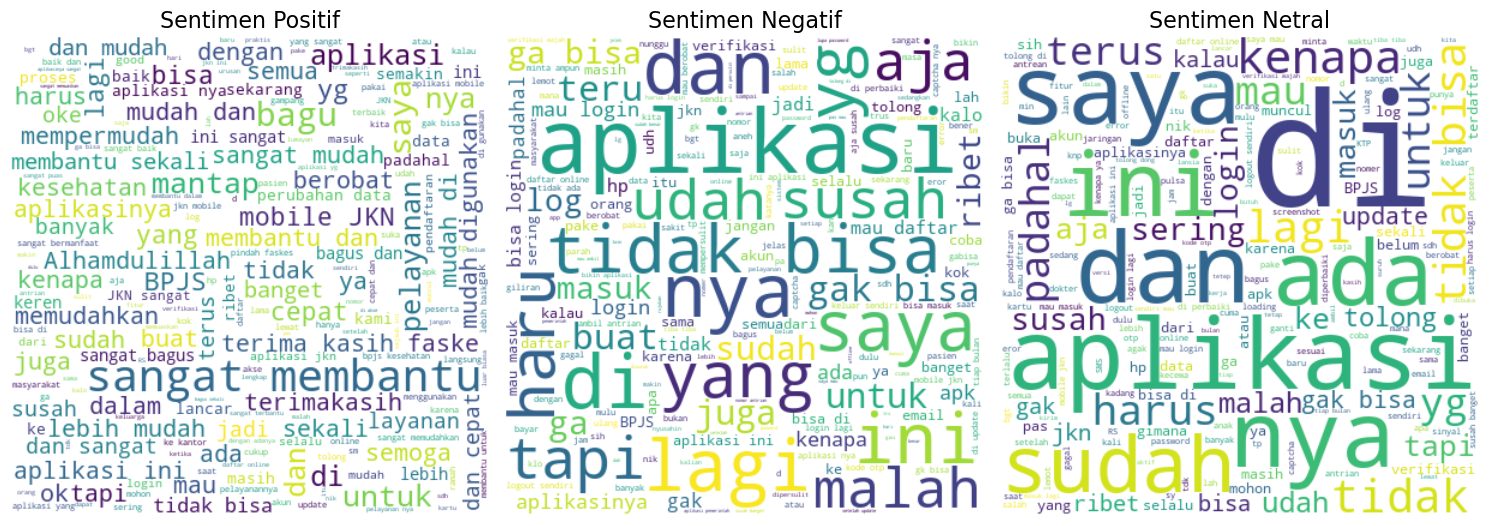

In [143]:

df_cleaned['review_text'] = df_cleaned['review_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

positive_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 'Positive']['review_text'])
netral_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 'Neutral']['review_text'])
negative_text = ' '.join(df_cleaned[df_cleaned['sentiment'] == 'Negative']['review_text'])

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
wordcloud_pos = WordCloud(width=400, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Sentimen Positif', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
wordcloud_neg = WordCloud(width=400, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Sentimen Negatif', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
wordcloud_neu = WordCloud(width=400, height=400, background_color='white').generate(netral_text)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.title('Sentimen Netral', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


### Handle Imbalanced Data

In [30]:
negative_reviews = df_cleaned[df_cleaned['sentiment'] == 'Negative']
positive_reviews = df_cleaned[df_cleaned['sentiment'] == 'Positive']
neutral_reviews = df_cleaned[df_cleaned['sentiment'] == 'Neutral']

max_samples = max(len(negative_reviews), len(positive_reviews))

negative_upsampled = resample(negative_reviews, 
                               replace=True, 
                               n_samples=max_samples, 
                               random_state=42)

positive_upsampled = resample(positive_reviews, 
                               replace=True, 
                               n_samples=max_samples, 
                               random_state=42)

neutral_upsampled = resample(neutral_reviews, 
                              replace=True, 
                              n_samples=max_samples, 
                              random_state=42)

df_balanced = pd.concat([negative_upsampled, positive_upsampled, neutral_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print('Balanced Dataset:')
print(df_balanced['sentiment'].value_counts())
print(f'\nTotal samples: {len(df_balanced)}')

Balanced Dataset:
sentiment
Negative    3673
Positive    3673
Neutral     3673
Name: count, dtype: int64

Total samples: 11019


In [31]:
df_balanced.to_csv('./data/data_clean.csv', index=False)
df_balanced.head()

,review_id,rating,review_text,cleaned_text,sentiment
0,3c43a078-1abc-4618-953a-d29505ba312b,1,kenapa skrg tidak bisa di ss??? resiko besar a...,kenapa skrg tidak bisa di ss resiko besar apa ...,Negative
1,2dd34b10-e544-4749-8be5-652ce2cb30d3,5,bagus sekali 👍🏻,bagus sekali thumbs_up_light_skin_tone,Positive
2,08a85aac-ac5f-42a6-a303-20d83f0935cb,3,sulit login,sulit login,Neutral
3,306b305f-553a-4601-9835-146c3ef2fc52,5,woke,woke,Positive
4,8104f9af-a7f1-49d6-8c01-1ce75a751399,3,"jkn tidak bisa login, capca nya gak keluar",jkn tidak bisa login capca nya gak keluar,Neutral


## 4. Model Training

In [32]:
X = df_balanced['cleaned_text']
y = df_balanced['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training: {len(X_train)} samples')
print(f'Testing: {len(X_test)} samples')
print(f'\nTrain distribution:\n{y_train.value_counts()}')
print(f'\nTest distribution:\n{y_test.value_counts()}')

Training: 8815 samples
Testing: 2204 samples

Train distribution:
sentiment
Negative    2939
Neutral     2938
Positive    2938
Name: count, dtype: int64

Test distribution:
sentiment
Neutral     735
Positive    735
Negative    734
Name: count, dtype: int64


In [33]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f'TF-IDF features: {X_train_tfidf.shape[1]}')

TF-IDF features: 5000


### Logistic Regression

In [34]:
lr_model = LogisticRegression(max_iter=5000, 
                            random_state=42,
                            class_weight='balanced',
                            solver='lbfgs',
                            tol=1e-4,
                            n_jobs=-1)

lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

In [35]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print('Logistic Regression:')
print(f'Accuracy: {lr_accuracy:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall: {lr_recall:.4f}')
print(f'F1-Score: {lr_f1:.4f}')
print(f'\n{classification_report(y_test, y_pred_lr)}')

Logistic Regression:
Accuracy: 0.9061
Precision: 0.9074
Recall: 0.9061
F1-Score: 0.9060

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89       734
     Neutral       0.88      0.95      0.91       735
    Positive       0.94      0.89      0.92       735

    accuracy                           0.91      2204
   macro avg       0.91      0.91      0.91      2204
weighted avg       0.91      0.91      0.91      2204



Text(45.722222222222214, 0.5, 'True Label')

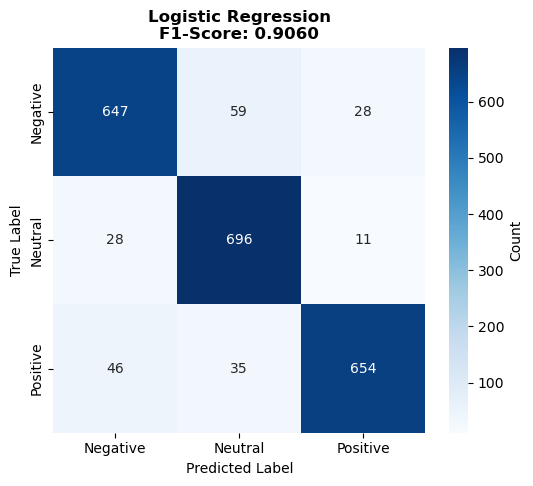

In [61]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_, 
            yticklabels=lr_model.classes_,
            ax=axes, cbar_kws={'label': 'Count'})
axes.set_title(f'Logistic Regression\nF1-Score: {lr_f1:.4f}', fontsize=12, fontweight='bold')
axes.set_xlabel('Predicted Label')
axes.set_ylabel('True Label')

### Naive Bayes

In [36]:
nb_model = MultinomialNB(alpha=0.5, 
                         fit_prior=True)
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

In [37]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb, average='weighted')
nb_recall = recall_score(y_test, y_pred_nb, average='weighted')
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')

print('Naive Bayes:')
print(f'Accuracy: {nb_accuracy:.4f}')
print(f'Precision: {nb_precision:.4f}')
print(f'Recall: {nb_recall:.4f}')
print(f'F1-Score: {nb_f1:.4f}')
print(f'\n{classification_report(y_test, y_pred_nb)}')

Naive Bayes:
Accuracy: 0.8235
Precision: 0.8466
Recall: 0.8235
F1-Score: 0.8251

              precision    recall  f1-score   support

    Negative       0.70      0.93      0.80       734
     Neutral       0.91      0.73      0.81       735
    Positive       0.93      0.81      0.87       735

    accuracy                           0.82      2204
   macro avg       0.85      0.82      0.83      2204
weighted avg       0.85      0.82      0.83      2204



Text(45.722222222222214, 0.5, 'True Label')

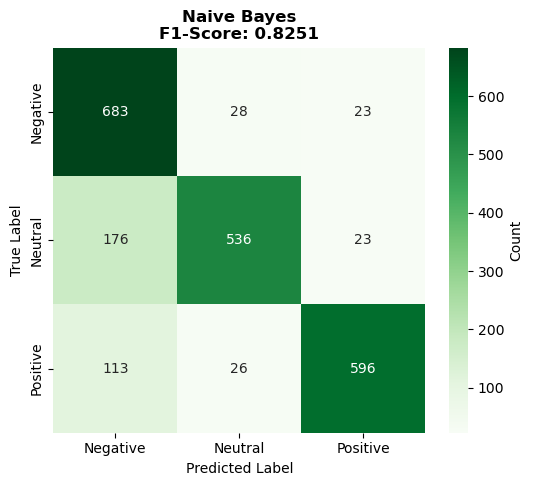

In [63]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=nb_model.classes_, 
            yticklabels=nb_model.classes_,
            ax=axes, cbar_kws={'label': 'Count'})
axes.set_title(f'Naive Bayes\nF1-Score: {nb_f1:.4f}', fontsize=12, fontweight='bold')
axes.set_xlabel('Predicted Label')
axes.set_ylabel('True Label')

### DistilBERT

In [38]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=48):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [39]:
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
label_reverse_mapping = {v: k for k, v in label_mapping.items()}

y_train_encoded = y_train.map(label_mapping).reset_index(drop=True)
y_test_encoded = y_test.map(label_mapping).reset_index(drop=True)

In [40]:
print(f'Training samples: {len(X_train):,}')
print(f'Test samples: {len(X_test):,}')
print(f'\nTrain distribution:')
print(y_train.value_counts())

Training samples: 8,815
Test samples: 2,204

Train distribution:
sentiment
Negative    2939
Neutral     2938
Positive    2938
Name: count, dtype: int64


In [41]:
y_train_encoded = y_train.map(label_mapping).reset_index(drop=True)
y_test_encoded = y_test.map(label_mapping).reset_index(drop=True)

tokenizer = DistilBertTokenizer.from_pretrained('cahya/distilbert-base-indonesian')

train_dataset = ReviewDataset(
    X_train.reset_index(drop=True),
    y_train_encoded,
    tokenizer
)

test_dataset = ReviewDataset(
    X_test.reset_index(drop=True),
    y_test_encoded,
    tokenizer
)

#### Load Model with LoRA

In [42]:
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    'cahya/distilbert-base-indonesian',
    num_labels=3
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    bias="none"
)

distilbert_model = get_peft_model(distilbert_model, lora_config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

trainable_params = sum(p.numel() for p in distilbert_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in distilbert_model.parameters())

print(f'Model loaded on: {device}')
print(f'Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)')
print(f'Total parameters: {total_params:,}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cpu
Trainable parameters: 1,182,723 (1.71%)
Total parameters: 69,273,606


In [53]:
def compute_metrics(pred):
    labels = pred.label_ids
    if isinstance(pred.predictions, tuple):
        preds = pred.predictions[0].argmax(-1)
    else:
        preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

num_epochs = 2
eval_steps = 150
batch_size = 32

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    warmup_steps=150,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='steps',
    eval_steps=eval_steps,
    save_strategy='steps',
    save_steps=eval_steps,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=False,
    optim='adamw_torch',
    learning_rate=0.0001,
    lr_scheduler_type='cosine',
    save_total_limit=2,
    dataloader_num_workers=0,
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [54]:
print('Training DistilBERT...')
trainer.train()

Training DistilBERT...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
150,0.565300,0.579612,0.739564,0.747871,0.739564,0.740922
300,0.532300,0.524762,0.773140,0.788163,0.773140,0.773999
450,0.499900,0.487781,0.795826,0.807281,0.795826,0.798336


TrainOutput(global_step=552, training_loss=0.5384253375772117, metrics={'train_runtime': 2884.122, 'train_samples_per_second': 6.113, 'train_steps_per_second': 0.191, 'total_flos': 224952881961600.0, 'train_loss': 0.5384253375772117, 'epoch': 2.0})

In [55]:
distilbert_model.eval()
predictions = []
true_labels = []

for i in range(len(test_dataset)):
    item = test_dataset[i]
    input_ids = item['input_ids'].unsqueeze(0).to(device)
    attention_mask = item['attention_mask'].unsqueeze(0).to(device)
    label = item['labels'].item()
    
    with torch.no_grad():
        outputs = distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
    
    predictions.append(pred)
    true_labels.append(label)

y_pred_bert_labels = [label_reverse_mapping[p] for p in predictions]
y_test_labels = [label_reverse_mapping[t] for t in true_labels]

bert_accuracy = accuracy_score(true_labels, predictions)
bert_precision = precision_score(true_labels, predictions, average='weighted')
bert_recall = recall_score(true_labels, predictions, average='weighted')
bert_f1 = f1_score(true_labels, predictions, average='weighted')

print('DistilBERT:')
print(f'Accuracy: {bert_accuracy:.4f}')
print(f'Precision: {bert_precision:.4f}')
print(f'Recall: {bert_recall:.4f}')
print(f'F1-Score: {bert_f1:.4f}')
print(f'\n{classification_report(y_test_labels, y_pred_bert_labels)}')

DistilBERT:
Accuracy: 0.7958
Precision: 0.8073
Recall: 0.7958
F1-Score: 0.7983

              precision    recall  f1-score   support

    Negative       0.78      0.71      0.74       734
     Neutral       0.69      0.82      0.75       735
    Positive       0.95      0.86      0.90       735

    accuracy                           0.80      2204
   macro avg       0.81      0.80      0.80      2204
weighted avg       0.81      0.80      0.80      2204



Text(45.722222222222214, 0.5, 'True Label')

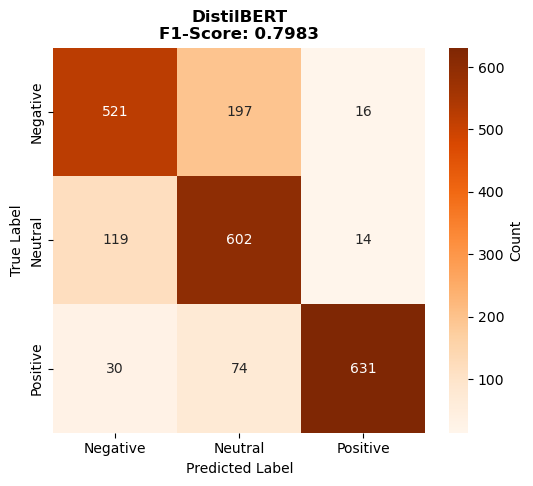

In [67]:
cm_bert = confusion_matrix(y_test_labels, y_pred_bert_labels)
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
labels = sorted(label_mapping.keys())
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=labels, 
            yticklabels=labels,
            ax=axes, cbar_kws={'label': 'Count'})
axes.set_title(f'DistilBERT\nF1-Score: {bert_f1:.4f}', fontsize=12, fontweight='bold')
axes.set_xlabel('Predicted Label')
axes.set_ylabel('True Label')

## 6. Model Comparison

In [56]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'DistilBERT'],
    'Accuracy': [lr_accuracy, nb_accuracy, bert_accuracy],
    'Precision': [lr_precision, nb_precision, bert_precision],
    'Recall': [lr_recall, nb_recall, bert_recall],
    'F1-Score': [lr_f1, nb_f1, bert_f1]
})

print('Model Performance Comparison:')
print(comparison_df.to_string(index=False))

best_model = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f'\nBest Model: {best_model}')
print(f'Best F1-Score: {comparison_df["F1-Score"].max():.4f}')

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.906080   0.907371 0.906080  0.906041
        Naive Bayes  0.823503   0.846565 0.823503  0.825148
         DistilBERT  0.795826   0.807281 0.795826  0.798336

Best Model: Logistic Regression
Best F1-Score: 0.9060


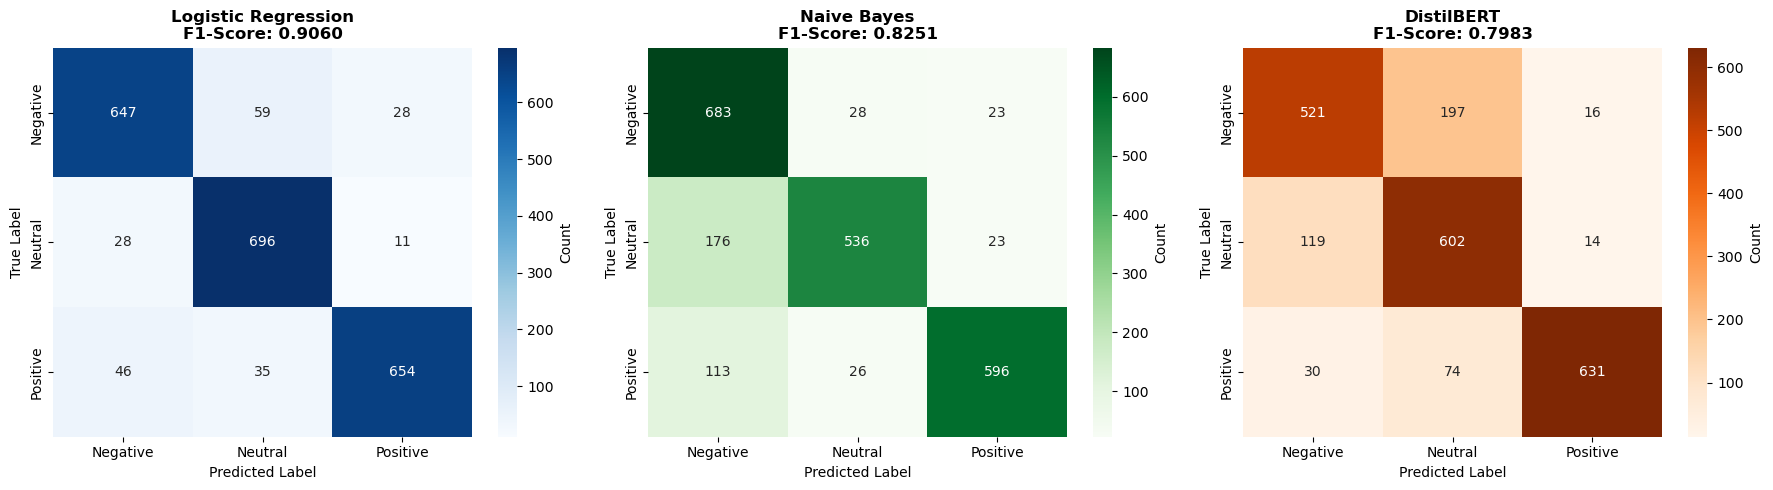

In [58]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_bert = confusion_matrix(y_test_labels, y_pred_bert_labels)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix - Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_, 
            yticklabels=lr_model.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Logistic Regression\nF1-Score: {lr_f1:.4f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Confusion Matrix - Naive Bayes
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=nb_model.classes_, 
            yticklabels=nb_model.classes_,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Naive Bayes\nF1-Score: {nb_f1:.4f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Confusion Matrix - DistilBERT
labels = sorted(label_mapping.keys())
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=labels, 
            yticklabels=labels,
            ax=axes[2], cbar_kws={'label': 'Count'})
axes[2].set_title(f'DistilBERT\nF1-Score: {bert_f1:.4f}', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()